Generates data for tests in `test_dist_enum`.

In [1]:
%load_ext autoreload
%autoreload 2

The test that compares two different ways of enumerating products in `tests/test_dist_enum.py`.

In [10]:
from pathlib import Path

import asf_search as asf
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pandas.testing import assert_frame_equal
from rasterio.crs import CRS
from shapely.geometry import Point
from tqdm import tqdm

from dist_s1_enumerator.mgrs_burst_data import (
    get_burst_ids_in_mgrs_tiles,
    get_burst_table,
    get_burst_table_from_mgrs_tiles,
    get_mgrs_table,
    get_mgrs_tile_table_by_ids,
    get_mgrs_tiles_overlapping_geometry,
)

In [41]:
SITE = "wax_lake"  # 'los_angeles', 'greenland', 'wax_lake'

CONFIG = {
    "wax_lake": {
        "geo": Point(-91.45, 29.5),
        "mgrs_tile_ids": ["15RXN"],
        "track_numbers": [63],
    },
    "los_angeles": {
        "geo": Point(-118, 34).buffer(0.25),
        "mgrs_tile_ids": ["11SLT", "11SLU", "11SMT"],
        "track_numbers": None,
    },
    "greenland": {
        "geo": Point(-46, 71),
        "mgrs_tile_ids": ["22WFD"],
        "track_numbers": None,
    },
    "aleuatian_antimeridian": {
        "geo": Point(179.87, 51.86),
        "mgrs_tile_ids": ["01UBT"],
        "track_numbers": None,
    },
    # NO data available...
    # "ilha_mexiana": {
    #     "geo": Point(-49.75, 0).buffer(0.2),
    #     "mgrs_tile_ids": ["22NFF"],
    #     "track_numbers": [148],
    # },
}

DATA = CONFIG[SITE]
DATA

KeyError: 'ilha_mexiana'

In [25]:
geo = DATA["geo"]
df_aoi = gpd.GeoDataFrame(geometry=[geo], crs=CRS.from_epsg(4326))
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(geo)
df_mgrs_tiles.head()

,mgrs_tile_id,utm_epsg,utm_wkt,geometry
0,22MFE,32722,"MULTIPOLYGON(((600000 10000000,600000 9890200,...","POLYGON ((-50.10136 0, -50.10123 -0.99327, -49..."
1,22NFF,32622,"MULTIPOLYGON(((600000 100020,600000 -9780,7098...","POLYGON ((-50.10125 0.9048, -50.10136 -0.08847..."


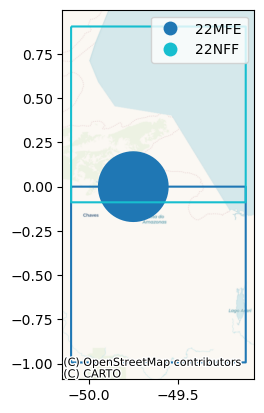

In [26]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, legend=True, ax=ax
)
df_aoi.plot(ax=ax)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)
if SITE == "aleuatian_antimeridian":
    ax.set_xlim(178, 180)

In [27]:
mgrs_tile_ids = DATA["mgrs_tile_ids"]
mgrs_tile_ids

['22NFF']

In [28]:
df_bursts = get_burst_table_from_mgrs_tiles(mgrs_tile_ids)
df_bursts.head()

,jpl_burst_id,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id,geometry
0,T046-098796-IW3,46,0,22NFF,"POLYGON ((-50.34787 -0.41517, -49.643 -0.26769..."
1,T046-098797-IW3,46,0,22NFF,"POLYGON ((-50.38528 -0.24916, -49.68025 -0.101..."
2,T046-098798-IW3,46,0,22NFF,"POLYGON ((-50.42043 -0.08269, -49.7154 0.06444..."
3,T046-098799-IW3,46,0,22NFF,"POLYGON ((-50.45554 0.08379, -49.7505 0.23072,..."
4,T046-098800-IW3,46,0,22NFF,"POLYGON ((-50.49061 0.25027, -49.78556 0.39701..."


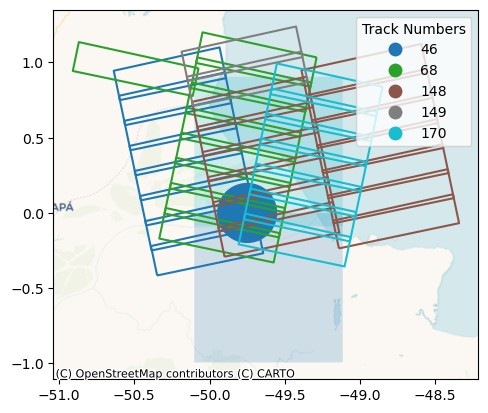

In [29]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2
)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column="track_number", categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title("Track Numbers")
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)
if SITE == "aleuatian_antimeridian":
    ax.set_xlim(178, 180)

In [30]:
delta_window_days = 365
delta_lookback_days = 0
max_pre_imgs_per_burst = 10

# Example test

In [37]:
from dist_s1_enumerator.asf import get_rtc_s1_ts_metadata_from_mgrs_tiles
from dist_s1_enumerator.dist_enum import (
    enumerate_dist_s1_products,
    enumerate_one_dist_s1_product,
)

In [38]:
track_numbers = DATA["track_numbers"]
track_numbers

[148]

In [39]:
df_ts = get_rtc_s1_ts_metadata_from_mgrs_tiles(
    mgrs_tile_ids, track_numbers=track_numbers
)
df_ts.head()

/Users/cmarshak/bekaert-team/dist-s1-enumerator/src/dist_s1_enumerator/asf.py:92: UserWarning: No results - please check burst id and availability.
  warn('No results - please check burst id and availability.', category=UserWarning)
/Users/cmarshak/bekaert-team/dist-s1-enumerator/src/dist_s1_enumerator/asf.py:268: UserWarning: No RTC S1 metadata found for  MGRS tile 22NFF. Track numbers provided: 148.
  warn(msg)


,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token


In [34]:
df_ts.track_number.unique()

array([], dtype=object)

In [35]:
data_dir = Path("rtc_s1_ts_metadata")
data_dir.mkdir(exist_ok=True, parents=True)

mgrs_tile_token = "_".join(mgrs_tile_ids)
file_name = f"mgrs{mgrs_tile_token}.parquet"
if track_numbers is not None:
    track_token = "_".join(list(map(str, track_numbers)))
    file_name = file_name.replace(".parquet", f"__track{track_token}.parquet")
df_ts.to_parquet(data_dir / file_name)

In [36]:
df_products = enumerate_dist_s1_products(df_ts, mgrs_tile_ids)
df_products.head()

SchemaError: expected series 'acq_dt' to have type datetime64[ns, UTC], got object

In [ ]:
df_post = df_products[df_products.input_category == "post"].reset_index(
    drop=True
)
df_tmp = (
    df_post[
        [
            "product_id",
            "acq_date_for_mgrs_pass",
            "track_number",
            "mgrs_tile_id",
            "track_token",
        ]
    ]
    .drop_duplicates(subset="product_id")
    .sort_values(by="acq_date_for_mgrs_pass")
)
mgrs_tile_ids_post = df_tmp["mgrs_tile_id"].tolist()
product_ids = df_tmp["product_id"].tolist()
post_dates = df_tmp["acq_date_for_mgrs_pass"].tolist()
track_tokens_post = df_tmp["track_token"].tolist()
track_numbers_post_lst = [
    [int(track) for track in token.split("_")] for token in track_tokens_post
]

In [ ]:
for mgrs_tile_id_post, product_id, track_numbers_post, post_date in tqdm(
    zip(mgrs_tile_ids_post, product_ids, track_numbers_post_lst, post_dates),
    total=len(post_dates),
):
    df_one_product = enumerate_one_dist_s1_product(
        mgrs_tile_id_post,
        track_number=track_numbers_post,
        post_date=pd.Timestamp(post_date),
    )
    df_one_product_alt = (
        df_products[df_products.product_id == product_id]
        .reset_index(drop=True)
        .drop(columns="product_id")
    )
    df_pre_alt = df_one_product_alt[
        df_one_product_alt.input_category == "pre"
    ].reset_index(drop=True)
    df_post_alt = df_one_product_alt[
        df_one_product_alt.input_category == "post"
    ].reset_index(drop=True)

    df_pre = df_one_product[df_one_product.input_category == "pre"].reset_index(
        drop=True
    )
    df_post = df_one_product[
        df_one_product.input_category == "post"
    ].reset_index(drop=True)

    assert_frame_equal(df_pre, df_pre_alt, atol=1e-7)
    assert_frame_equal(df_post, df_post, atol=1e-7)
    break